In [32]:
!uv pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!uv pip install kaggle
!uv pip install matplotlib

Audited 3 packages in 2ms
Audited 1 package in 1ms
Audited 1 package in 1ms


In [24]:
!kaggle datasets download \
  -d honeybadger128bit/multispectral-field-images \
  -p ./data/multispectral-field-images \
  --unzip


403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/metadata/honeybadger128bit/multispectral-field-images


# Sources:
https://github.com/satellite-image-deep-learning/datasets

https://github.com/Agri-Hub/Callisto-Dataset-Collection?tab=readme-ov-file

https://zenodo.org/records/6866847

In [ ]:
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd

def download_kaggle_dataset(dataset_slug: str, target_dir: str, unzip: bool = True):
    """
    Downloads a Kaggle dataset and (optionally) unzips it.

    :param dataset_slug: The Kaggle dataset identifier, e.g. "honeybadger128bit/multespectral-field-images"
    :param target_dir: Where to download / extract the dataset
    :param unzip: Whether to unzip the downloaded zip file(s)
    """
    api = KaggleApi()
    api.authenticate()

    os.makedirs(target_dir, exist_ok=True)

    print(f"Downloading dataset {dataset_slug} to {target_dir} …")
    api.dataset_download_files(dataset_slug, path=target_dir, unzip=False)

    # Find downloaded zip(s) and optionally unzip
    for fname in os.listdir(target_dir):
        if fname.endswith(".zip"):
            full_path = os.path.join(target_dir, fname)
            print(f"Found zip: {full_path}")
            if unzip:
                print(f"Unzipping {full_path} …")
                with zipfile.ZipFile(full_path, 'r') as z:
                    z.extractall(target_dir)
                print(f"Removing zip file {full_path}")
                os.remove(full_path)

def load_dataset_as_dataframe(data_dir: str) -> pd.DataFrame:
    """
    Load the dataset into a pandas DataFrame. Because this is a multispectral image dataset,
    there may be no “tabular” data, so this function instead scans the directory structure
    and builds a DataFrame with paths and possibly labels (if directory names encode labels).

    :param data_dir: Directory where dataset is extracted
    :return: pandas DataFrame with (at least) file paths and possibly other metadata
    """
    rows = []
    # Walk through the directory
    for root, dirs, files in os.walk(data_dir):
        for f in files:
            # you can filter by extension if needed, e.g. .tif, .jpg, etc.
            if f.lower().endswith((".tif", ".tiff", ".png", ".jpg")):
                full_path = os.path.join(root, f)

                # Example: infer a "label" from parent directory
                label = os.path.basename(root)

                rows.append({
                    "file_path": full_path,
                    "label": label,
                })

    df = pd.DataFrame(rows)
    return df

if __name__ == "__main__":
    # Example usage
    dataset = "honeybadger128bit/multespectral-field-images"
    target_directory = "data/multispectral_images"

    download_kaggle_dataset(dataset, target_directory, unzip=True)

    df = load_dataset_as_dataframe(target_directory)
    print(df.head())
    print(f"Number of images: {len(df)}")

    # Save to CSV for later use
    df.to_csv(os.path.join(target_directory, "image_paths.csv"), index=False)


Dataset URL: https://www.kaggle.com/datasets/honeybadger128bit/multespectral-field-images
Found zip: data/multispectral_images/multespectral-field-images.zip
Unzipping data/multispectral_images/multespectral-field-images.zip …
Removing zip file data/multispectral_images/multespectral-field-images.zip
Empty DataFrame
Columns: []
Index: []
Number of images: 0


In [29]:
import os
import json
import numpy as np
import pandas as pd

def load_multispectral_jsons(json_dir: str) -> pd.DataFrame:
    """
    Load all JSON files in json_dir, parse them, and return a DataFrame
    with spectral data (possibly as numpy arrays) + metadata.
    """
    records = []
    for root, dirs, files in os.walk(json_dir):
        for fname in files:
            if not fname.lower().endswith(".json"):
                continue
            full_path = os.path.join(root, fname)
            with open(full_path, 'r') as f:
                try:
                    data = json.load(f)
                except json.JSONDecodeError as e:
                    print(f"Error reading {full_path}: {e}")
                    continue

            record = {
                "json_filename": fname,
                "json_path": full_path,
            }

            # Spectral data
            if "data" in data:
                try:
                    spectral = np.array(data["data"])
                except Exception:
                    spectral = data["data"]
                record["spectral_data"] = spectral
            else:
                record["spectral_data"] = None

            # Add other metadata keys
            for k, v in data.items():
                if k == "data":
                    continue
                record[k] = v

            records.append(record)

    df = pd.DataFrame(records)
    return df

if __name__ == "__main__":
    base_dir = "data/multispectral_images"
    json_dir = os.path.join(base_dir, "images")

    df = load_multispectral_jsons(json_dir)
    print("Loaded JSON DF:", df.shape)
    print(df.head())
    print(df.info())

    # Optionally save the DataFrame (but spectral_data may be large).
    df.to_pickle(os.path.join(base_dir, "multispectral_data.pkl"))


Loaded JSON DF: (1598, 3)
                     json_filename  \
0  field2_image230_2018-04-21.json   
1    field1_image1_2017-03-29.json   
2  field1_image278_2019-08-01.json   
3  field2_image222_2018-04-08.json   
4  field1_image353_2020-07-04.json   

                                           json_path  \
0  data/multispectral_images/images/field2_image2...   
1  data/multispectral_images/images/field1_image1...   
2  data/multispectral_images/images/field1_image2...   
3  data/multispectral_images/images/field2_image2...   
4  data/multispectral_images/images/field1_image3...   

                                       spectral_data  
0  [[[8854, 8484, 7965, 7893, 8312, 8223, 8192, 8...  
1  [[[11644, 10334, 9187, 8937, 9203, 9268, 9348,...  
2  [[[437, 499, 690, 641, 1139, 2874, 3696, 3765,...  
3  [[[424, 490, 561, 717, 780, 839, 933, 1050, 10...  
4  [[[398, 380, 562, 515, 874, 2264, 2763, 2778, ...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598 entries, 0 to 1597
Data

Selected record metadata:
  json_filename: field2_image230_2018-04-21.json
  json_path: data/multispectral_images/images/field2_image230_2018-04-21.json
Spectral data shape (H, W, bands): 111, 113, 14


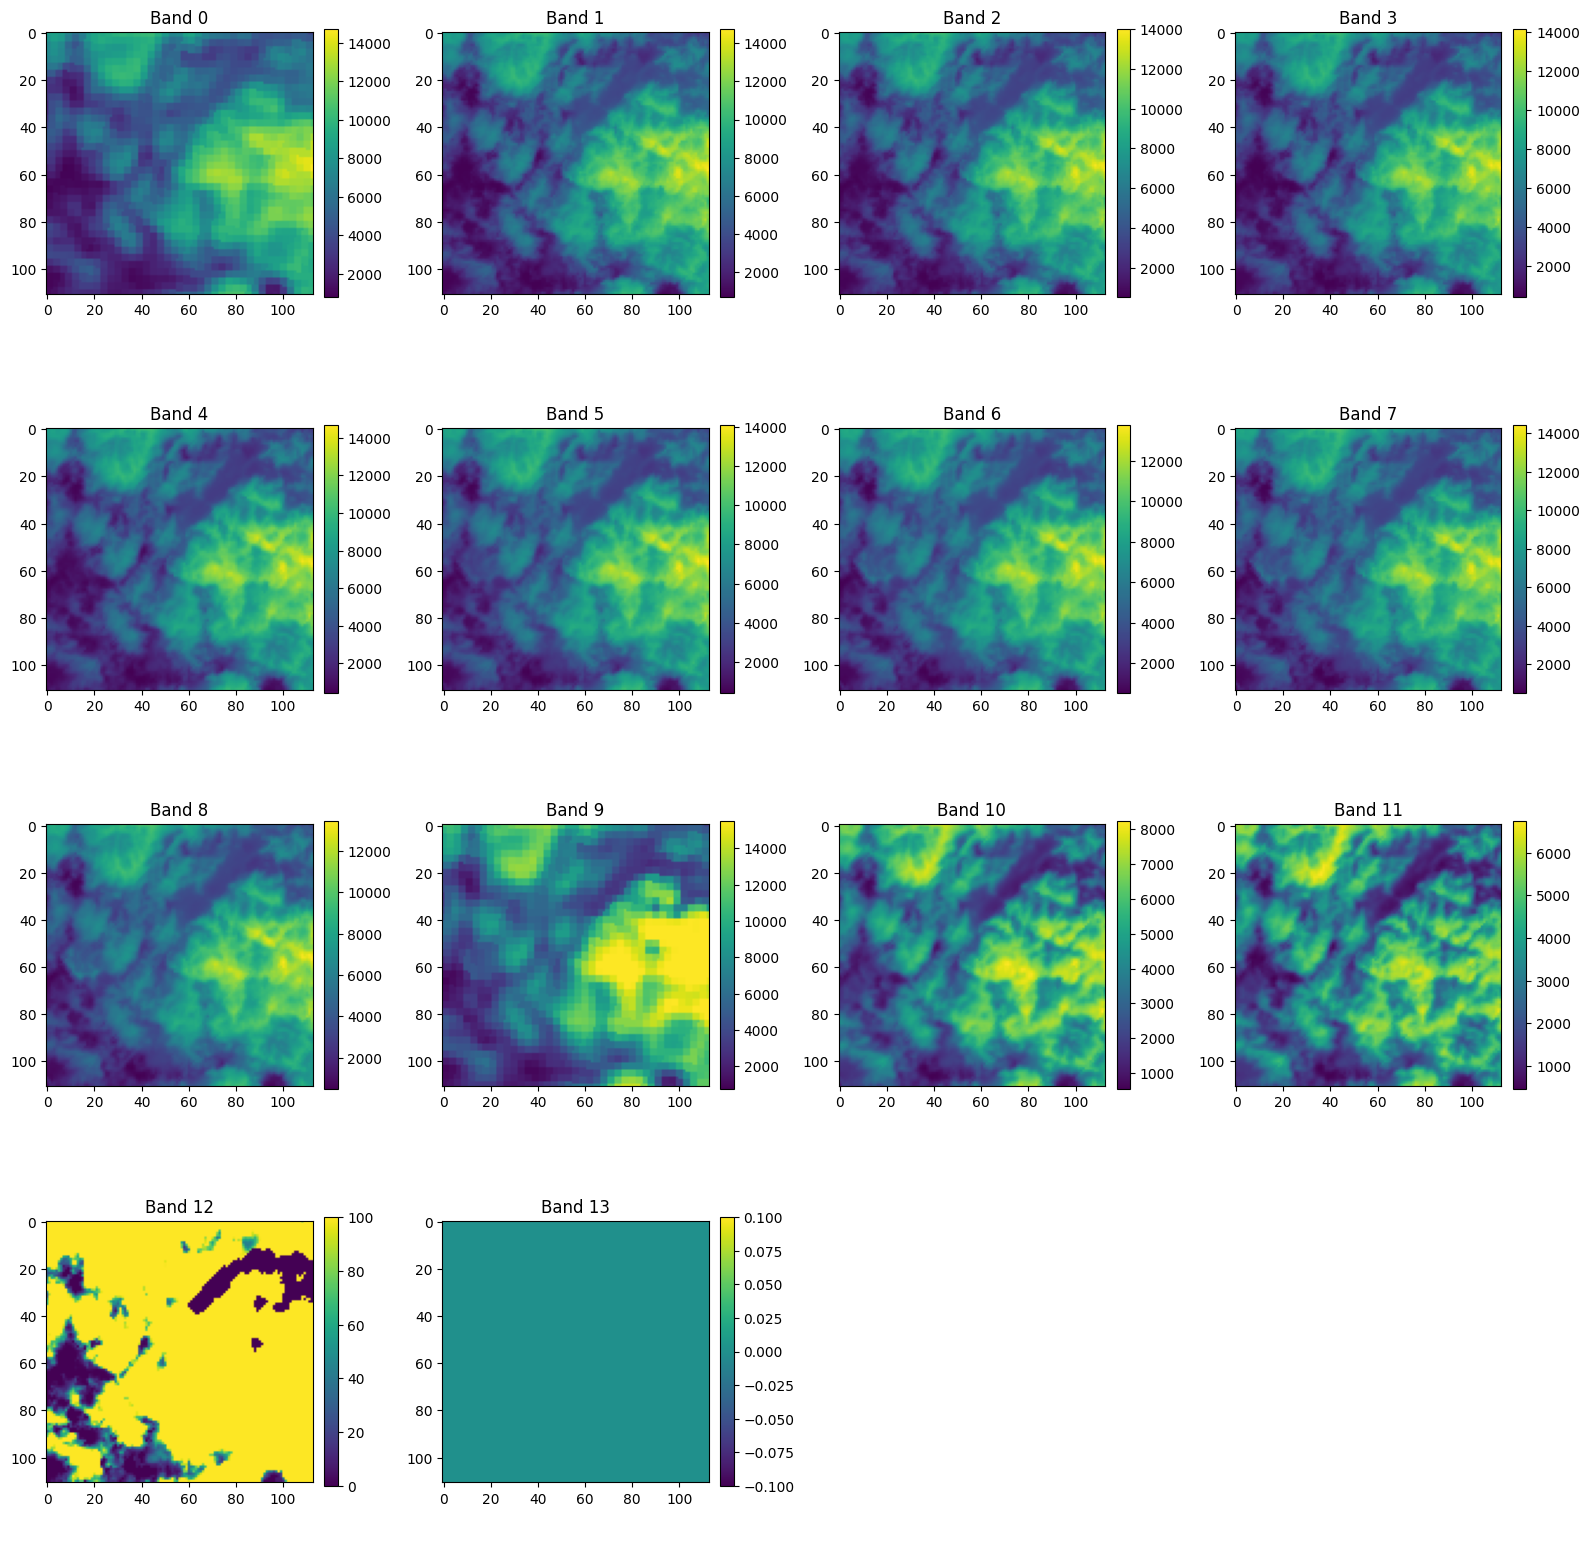